### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

import coldic as cd
reload(cd)

<module 'coldic' from '/gpfs/scratch/mep22dku/windEval/plottingCode/coldic.py'>

## visualize SAM ts

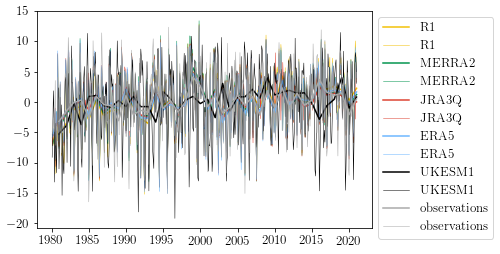

In [4]:
prods = ['NCEP-NCAR','MERRA','JRA','ERA5','UKESM','obs']


# prods = ['UKESM']

plt.figure

for prod in prods:
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    
    wmn = w.resample(time='Y').mean()
    
    plt.plot(wmn.time,wmn.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'])
    plt.plot(w.time,w.SAM, color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = 0.5)

plt.legend(bbox_to_anchor = [1, 1])
    

In [10]:
w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/ERA5/SAM.nc')
w

<xarray.Dataset>
Dimensions:  (time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2020-12-31
Data variables:
    slp40S   (time) float64 ...
    slp65S   (time) float64 ...
    SAM      (time) float64 ...

## trends fxn

In [5]:

import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p


## extract trends and significances for SAM ts

In [6]:
dss = ['ERA5','NCEP-NCAR','MERRA','JRA','UKESM','obs']
# tdar = [era_ts, ncar_ts, merra_ts, doe_ts,  ukesm_ts]

data = np.zeros([5,6])
sig = np.zeros([5,6])
for i in range(0,6):
    
    prod = dss[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    data[0,i] = lin_slope* 10
    sig[0,i] = lin_p
    
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[1,i] = lin_slope* 10
    sig[1,i] = lin_p    

    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'MAM'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[2,i] = lin_slope* 10
    sig[2,i] = lin_p   
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'JJA'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[3,i] = lin_slope* 10
    sig[3,i] = lin_p   
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'SON'))
    wq = wy.sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[4,i] = lin_slope* 10
    sig[4,i] = lin_p   
            
    i = i+1
    
#dss = ['ERA5','NCEP-NCAR','MERRA','JRA3Q','UKESM','obs']
df = pd.DataFrame(data, columns=['ERA5','NCEP-NCAR','MERRA','JRA3Q','UKESM','obs'],\
                  index  = ['full year','DJF','MAM','JJA','SON'])
df2 = pd.DataFrame(sig, columns=['ERA5','NCEP-NCAR','MERRA','JRA3Q','UKESM','obs'],\
                  index  = ['full year','DJF','MAM','JJA','SON'])

df.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df.to_csv(f'./plts/SAM_trend-1980-2019.csv')
df2.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df2.to_csv(f'./plts/SAM_trendsig-1980-2019.csv')

####
data = np.zeros([5,6])
sig = np.zeros([5,6])
for i in range(0,6):
    
    prod = dss[i]
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    data[0,i] = lin_slope* 10
    sig[0,i] = lin_p
    
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[1,i] = lin_slope* 10
    sig[1,i] = lin_p    

    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'MAM'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[2,i] = lin_slope* 10
    sig[2,i] = lin_p   
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'JJA'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[3,i] = lin_slope* 10
    sig[3,i] = lin_p   
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'SON'))
    wq = wy.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wq)
    data[4,i] = lin_slope* 10
    sig[4,i] = lin_p   
            
    i = i+1
    
#dss = ['ERA5','NCEP-NCAR','MERRA','JRA3Q','UKESM','obs']
df = pd.DataFrame(data, columns=['ERA5','NCEP-NCAR','MERRA','JRA3Q','UKESM','obs'],\
                  index  = ['full year','DJF','MAM','JJA','SON'])
df2 = pd.DataFrame(sig, columns=['ERA5','NCEP-NCAR','MERRA','JRA3Q','UKESM','obs'],\
                  index  = ['full year','DJF','MAM','JJA','SON'])

df.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df.to_csv(f'./plts/SAM_trend-1980-1999.csv')
df2.attrs = {"made in": 'plottingCode/Fig-SAM.ipynb'}
df2.to_csv(f'./plts/SAM_trendsig-1980-1999.csv')

## load wspd/SAM trends

In [7]:
wspd_trend = pd.read_csv(f'./plts/mn_wspd_trend-1980-2019.csv', index_col=0)
wspd_sig = pd.read_csv(f'./plts/mn_wspd_trendsig-1980-2019.csv', index_col=0)

wspd_trend80 = pd.read_csv(f'./plts/mn_wspd_trend-1980-1999.csv', index_col=0)
wspd_sig80 = pd.read_csv(f'./plts/mn_wspd_trendsig-1980-1999.csv', index_col=0)

SAM_trend80 = pd.read_csv(f'./plts/SAM_trend-1980-1999.csv', index_col=0)
SAM_sig80 = pd.read_csv(f'./plts/SAM_trendsig-1980-1999.csv', index_col=0)

SAM_trend = pd.read_csv(f'./plts/SAM_trend-1980-2019.csv', index_col=0)
SAM_sig = pd.read_csv(f'./plts/SAM_trendsig-1980-2019.csv', index_col=0)

## linear regression scatterplot

In [8]:
from scipy.stats import linregress

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']#,'obs']

sams = []
winds = []

for i in range(0,5):
    x = SAM_trend.at['full year', f'{prods[i]}']
    xs = SAM_sig.at['full year', f'{prods[i]}']

    y = wspd_trend.at['full year', f'{prods[i]}']
    ys = wspd_sig.at['full year', f'{prods[i]}']
    

    if ((xs < 0.05) & (ys < 0.05)):
        sams.append(x)
        winds.append(y)
    
    x = SAM_trend80.at['full year', f'{prods[i]}']
    xs = SAM_sig80.at['full year', f'{prods[i]}']

    y = wspd_trend80.at['full year', f'{prods[i]}']
    ys = wspd_sig80.at['full year', f'{prods[i]}']
    

    if ((xs < 0.05) & (ys < 0.05)):
        sams.append(x)
        winds.append(y)
        
slopeFY, interceptFY, r_valueFY, p_valueFY, std_err = linregress(sams, winds)
print(r_valueFY)

plt.figure()
plt.title('FY')
plt.plot(sams,winds, 'ro')

### DJF

from scipy.stats import linregress

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']#,'obs']

sams = []
winds = []

for i in range(0,5):
    x = SAM_trend.at['DJF', f'{prods[i]}']
    xs = SAM_sig.at['DJF', f'{prods[i]}']

    y = wspd_trend.at['DJF', f'{prods[i]}']
    ys = wspd_sig.at['DJF', f'{prods[i]}']
    

    if ((xs < 0.05) & (ys < 0.05)):
        sams.append(x)
        winds.append(y)
    
    x = SAM_trend80.at['DJF', f'{prods[i]}']
    xs = SAM_sig80.at['DJF', f'{prods[i]}']

    y = wspd_trend80.at['DJF', f'{prods[i]}']
    ys = wspd_sig80.at['DJF', f'{prods[i]}']
    

    if ((xs < 0.05) & (ys < 0.05)):
        sams.append(x)
        winds.append(y)
        
slopeDJF, interceptDJF, r_valueDJF, p_valueDJF, std_err = linregress(sams, winds)
print(r_valueDJF)



KeyError: 'UKESM'

In [ ]:
fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(8*fact, 4*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']#,'obs']
labs = ['MERRA','NCEP-NCAR','JRA','ERA5','UKESM']
xa = np.arange(1,6,1)

for i in range(0,5):
    x = SAM_trend.at['full year', f'{prods[i]}']
    xs = SAM_sig.at['full year', f'{prods[i]}']

    y = wspd_trend.at['full year', f'{prods[i]}']
    ys = wspd_sig.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10


    axs[0].plot(x, y, color = cd.prod[labs[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[labs[i]]['col'])
    if ((xs > 0.05) | (ys > 0.05)):
        axs[0].plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    
    #####
    
    x = SAM_trend80.at['full year', f'{prods[i]}']
    xs = SAM_sig80.at['full year', f'{prods[i]}']

    y = wspd_trend80.at['full year', f'{prods[i]}']
    ys = wspd_sig80.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    axs[0].plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[labs[i]]['col'])
    
    if ((xs > 0.05) | (ys > 0.05)):
        axs[0].plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
        
#### DFJ
for i in range(0,5):
    x = SAM_trend.at['DJF', f'{prods[i]}']
    xs = SAM_sig.at['DJF', f'{prods[i]}']

    y = wspd_trend.at['DJF', f'{prods[i]}']
    ys = wspd_sig.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10


    axs[1].plot(x, y, color = cd.prod[labs[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[labs[i]]['col'])
    if ((xs > 0.05) | (ys > 0.05)):
        axs[1].plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    
    #####
    
    x = SAM_trend80.at['DJF', f'{prods[i]}']
    xs = SAM_sig80.at['DJF', f'{prods[i]}']

    y = wspd_trend80.at['DJF', f'{prods[i]}']
    ys = wspd_sig80.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    axs[1].plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[labs[i]]['col'])
    
    if ((xs > 0.05) | (ys > 0.05)):
        axs[1].plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
    obst = SAM_trend.at['DJF', 'obs']
    axs[1].axvline(obst, color = 'grey')
    obst = SAM_trend.at['full year', 'obs']
    axs[0].axvline(obst, color = 'grey')
    
    obst = SAM_trend80.at['DJF', 'obs']
    axs[1].axvline(obst, color = 'grey', linestyle = ':')
    obst = SAM_trend80.at['full year', 'obs']
    axs[0].axvline(obst, color = 'grey', linestyle = ':')
    
for i in range(0,2):
    axs[i].set_xlim([0,3.5])
    axs[i].set_ylim([0,0.45])
    axs[i].set_xlabel('SAM trend (hPa decade $^{-1}$)')
    axs[i].set_ylabel('wind speed trend (m s$^{-1}$ decade$^{-1}$)')
    axs[0].set_title('Full year')
    axs[1].set_title('DJF')
    
xar = np.arange(0,4,0.2)
yar = xar*slopeFY + interceptFY
axs[0].plot(xar,yar)

xar = np.arange(0,4,0.2)
yar = xar*slopeDJF + interceptDJF
axs[1].plot(xar,yar)

axs[0].set_title(f'Full year \n r of lin. reg: {r_valueFY}')
axs[1].set_title(f'DJF \n r of lin. reg: {r_valueDJF}')

plt.tight_layout()

In [ ]:
fact = 1.2

# Create a figure and define the gridspec layout
fig = plt.figure(figsize=(7.5*fact, 10*fact))  # Adjust figure size as needed
gs = fig.add_gridspec(3, 2)
# Left two subplots with a 1.6:1 aspect ratio
ax1 = fig.add_subplot(gs[0, :])  # Top-left
ax2 = fig.add_subplot(gs[1, :])  # Bottom-left
# Right two subplots that are square
ax3 = fig.add_subplot(gs[2, 0])  # Top-right
ax4 = fig.add_subplot(gs[2, 1])  # Bottom-right



########
axs = axs.ravel()

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']#,'obs']
xa = np.arange(1,6,1)

for i in range(0,5):
    
    
    x = SAM_trend.at['full year', f'{prods[i]}']
    xs = SAM_sig.at['full year', f'{prods[i]}']

    y = wspd_trend.at['full year', f'{prods[i]}']
    ys = wspd_sig.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10
    if prods[i] == 'JRA3Q':
        lab = 'JRA'
    else:
        lab = prods[i]

    ax3.plot(x, y, color = cd.prod[lab]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
    if ((xs > 0.05) | (ys > 0.05)):
        ax3.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    if prods[i] == 'MERRA':
        ax3.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'], label = '1980-2019', linewidth = 0)    
    
    #####
    
    x = SAM_trend80.at['full year', f'{prods[i]}']
    xs = SAM_sig80.at['full year', f'{prods[i]}']

    y = wspd_trend80.at['full year', f'{prods[i]}']
    ys = wspd_sig80.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    ax3.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
    
    if prods[i] == 'MERRA':
        ax3.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'], label = '1980-1999')
    

    if ((xs > 0.05) | (ys > 0.05)):
        ax3.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
        
#### DFJ
for i in range(0,5):
    x = SAM_trend.at['DJF', f'{prods[i]}']
    xs = SAM_sig.at['DJF', f'{prods[i]}']

    y = wspd_trend.at['DJF', f'{prods[i]}']
    ys = wspd_sig.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10
    if prods[i] == 'JRA3Q':
        lab = 'JRA'
    else:
        lab = prods[i]
    
    ax4.plot(x, y, color = cd.prod[lab]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        

        
    if ((xs > 0.05) | (ys > 0.05)):
        ax4.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    
    #####
    
    x = SAM_trend80.at['DJF', f'{prods[i]}']
    xs = SAM_sig80.at['DJF', f'{prods[i]}']

    y = wspd_trend80.at['DJF', f'{prods[i]}']
    ys = wspd_sig80.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    ax4.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
    
    if ((xs > 0.05) | (ys > 0.05)):
        ax4.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
    obst = SAM_trend.at['DJF', 'obs']
    ax4.axvline(obst, color = 'grey')
    obst = SAM_trend.at['full year', 'obs']
    ax3.axvline(obst, color = 'grey')
    
    obst = SAM_trend80.at['DJF', 'obs']
    ax4.axvline(obst, color = 'grey', linestyle = ':')
    obst = SAM_trend80.at['full year', 'obs']
    ax3.axvline(obst, color = 'grey', linestyle = ':')
    
for ax in [ax3, ax4]:
    ax.set_xlim([0,3.5])
    ax.set_ylim([0,0.45])
    ax.set_xlabel('SAM trend (hPa decade $^{-1}$)')
    ax.set_ylabel('wind speed trend (m s$^{-1}$ decade$^{-1}$)')
    ax3.set_title('Full year')
    ax4.set_title('DJF')
    
xar = np.arange(0,4,0.2)
yar = xar*slopeFY + interceptFY
ax3.plot(xar,yar)

xar = np.arange(0,4,0.2)
yar = xar*slopeDJF + interceptDJF
ax4.plot(xar,yar)

ax3.set_title(f'Full year \n r of lin. reg: {r_valueFY}')
ax4.set_title(f'DJF \n r of lin. reg: {r_valueDJF}')
ax3.legend()

#
prods = ['MERRA','NCEP-NCAR','JRA','ERA5','UKESM','obs']


for prod in prods:
    
    
    if prod == 'JRA3Q':
        lab = 'JRA'
    else:
        lab = prod
        
    mkz = 'o'; ms = 10; lw = 1
    if prod == 'obs':
        mkz = '*'; ms = 20; lw = 3
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.resample(time='Y').mean()
    wmn2 = w.groupby('time.year').mean()
    ax1.plot(wmn2.year,wmn.SAM, color = cd.prod[lab]['col'], label = cd.prod[lab]['fnam'], linewidth = lw)

## FY
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.sel(time=(w['time.season'] == 'DJF')).resample(time='Y').mean()
    ax2.plot(wmn2.year,wmn.SAM, color = cd.prod[lab]['col'], label = cd.prod[lab]['fnam'], linewidth = lw)
    
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)


plt.tight_layout()

#fig.savefig('./plts/Fig-SAM.jpg', dpi = 300, bbox_inches='tight')

In [ ]:
#### DFJ

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']
plt.figure()

ss = ['full year', 'DJF','MAM','JJA','SON']
sm = ['Y', 'S', 'A', 'W', 'V']

for s in range(0,5):
    
    ts = ss[s]
    tm = sm[s]
    
    for i in range(0,5):
        x = SAM_trend.at[ts, f'{prods[i]}']
        xs = SAM_sig.at[ts, f'{prods[i]}']

        y = wspd_trend.at[ts, f'{prods[i]}']
        ys = wspd_sig.at[ts, f'{prods[i]}']

        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]

        plt.text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        plt.plot(x, y, color = cd.prod[lab]['col'], \
                    marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'], alpha = 0)

## seasonally subdivided trends

In [ ]:
#### DFJ

# obst = SAM_trend.at['DJF', 'obs']
# ax4.axvline(obst, color = 'grey')
# obst = SAM_trend.at['full year', 'obs']
# ax3.axvline(obst, color = 'grey')

# obst = SAM_trend80.at['DJF', 'obs']
# ax4.axvline(obst, color = 'grey', linestyle = ':')
# obst = SAM_trend80.at['full year', 'obs']
# ax3.axvline(obst, color = 'grey', linestyle = ':')

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']

fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(6*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']

ss = ['full year', 'DJF','MAM','JJA','SON']
sm = ['Y', 'S', 'A', 'W', 'V']

ind = 0
for s in range(0,5):
    
    ts = ss[s]
    tm = sm[s]
    
    obst = SAM_trend.at[ts, 'obs']
    axs[ind].axvline(obst, color = 'grey')
    obst = SAM_trend80.at[ts, 'obs']
    axs[ind].axvline(obst, color = 'grey', linestyle = ':')
    
    
    for i in range(0,5):
        x = SAM_trend.at[ts, f'{prods[i]}']
        xs = SAM_sig.at[ts, f'{prods[i]}']

        y = wspd_trend.at[ts, f'{prods[i]}']
        ys = wspd_sig.at[ts, f'{prods[i]}']

        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]

        #axs[ind].text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        axs[ind].plot(x, y, color = cd.prod[lab]['col'], \
                    marker = mkz, markersize = ms, \
                      markeredgecolor = cd.prod[lab]['col'], alpha = 1)

    for i in range(0,5):
        x = SAM_trend80.at[ts, f'{prods[i]}']
        xs = SAM_sig80.at[ts, f'{prods[i]}']

        y = wspd_trend80.at[ts, f'{prods[i]}']
        ys = wspd_sig80.at[ts, f'{prods[i]}']

        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]

        #axs[ind].text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        
        axs[ind].plot(x, y, color = 'w', \
                    marker = mkz, markersize = ms, \
                      markeredgecolor = cd.prod[lab]['col'], alpha = 1)
    
    
    axs[ind].set_title(f'{ss[ind]}')
    ind = ind+1

for i in range(0,6):
    axs[i].set_xlim([-0.5,3.5])
    axs[i].set_ylim([-0.05,0.4])
    axs[i].grid()
plt.tight_layout()

## MAIN plot: ts and 4 subdivided trends

In [ ]:
def moving_average(timeseries, n = 3):
    # Ensure n is valid and doesn't exceed the length of the timeseries
    if n <= 0 or n > len(timeseries):
        raise ValueError("Window size n must be between 1 and the length of the timeseries.")
    
    # Compute the n-point moving average
    return np.convolve(timeseries, np.ones(n) / n, mode='valid')

In [ ]:
fact = 1.1

# Create a figure and define the gridspec layout
fig = plt.figure(figsize=(7.*fact, 10*fact))  # Adjust figure size as needed
gs = fig.add_gridspec(3, 2)
# Left two subplots with a 1.6:1 aspect ratio
ax1 = fig.add_subplot(gs[0, :])  # Top-left
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])# Bottom-left
# Right two subplots that are square
ax4 = fig.add_subplot(gs[2, 0])  # Top-right
ax5 = fig.add_subplot(gs[2, 1])  # Bottom-right

axar = [ax2,ax3,ax4,ax5]

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']

ss = ['DJF','MAM','JJA','SON']
sm = ['Y', 'S', 'A', 'W', 'V']

ind = 0
for s in range(0,4):
    
    ts = ss[s]
    tm = sm[s]
    
    ax = axar[ind]
    
    obst = SAM_trend.at[ts, 'obs']
    ax.axvline(obst, color = 'b')
    obst = SAM_trend80.at[ts, 'obs']
    ax.axvline(obst, color = 'b', linestyle = ':')
    
    xa = []
    ya = []
    xas = []
    yas = []
    
    for i in range(0,5):
        x = SAM_trend.at[ts, f'{prods[i]}']
        xs = SAM_sig.at[ts, f'{prods[i]}']

        y = wspd_trend.at[ts, f'{prods[i]}']
        ys = wspd_sig.at[ts, f'{prods[i]}']

        if ((xs < 0.05) & (ys < 0.05)):
            xas.append(x)
            yas.append(y)
        xa.append(x)
        ya.append(y)
        
# 
        
        
        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]

        #axs[ind].text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        ax.plot(x, y, color = cd.prod[lab]['col'], \
                    marker = mkz, markersize = ms, \
                      markeredgecolor = cd.prod[lab]['col'], alpha = 1)
        if lab == 'MERRA':
            ax.plot(x, y, color = cd.prod[lab]['col'], \
                        marker = mkz, markersize = ms, \
                          markeredgecolor = cd.prod[lab]['col'], label = '1980-2019',  linewidth = 0, alpha = 1)
    #### 1980-1999
    for i in range(0,5):
        x = SAM_trend80.at[ts, f'{prods[i]}']
        xs = SAM_sig80.at[ts, f'{prods[i]}']

        y = wspd_trend80.at[ts, f'{prods[i]}']
        ys = wspd_sig80.at[ts, f'{prods[i]}']

        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]
            
        if ((xs < 0.05) & (ys < 0.05)):
            xas.append(x)
            yas.append(y)
        xa.append(x)
        ya.append(y)

        #axs[ind].text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        
        ax.plot(x, y, color = 'w', \
                    marker = mkz, markersize = ms, \
                      markeredgecolor = cd.prod[lab]['col'], alpha = 1)
        if lab == 'MERRA':
            ax.plot(x, y, color = 'w', \
                        marker = mkz, markersize = ms, \
                          markeredgecolor = cd.prod[lab]['col'], label = '1980-1999', alpha = 1)    
    
    ax.set_title(f'{ss[ind]}')
    slope, intercept, r_value, p_value, std_err = linregress(xa, ya)
    print(len(xa))
    print(f'{ss[ind]}, {r_value}, {p_value}')
    rounded_number = round(r_value, 2)
    ax.set_title(f'{ss[ind]} (r: {rounded_number})')
    
    ax.set_xlim([-0.5,3.5])
    ax.set_ylim([-0.05,0.4])
    ax.grid()
    ax.set_xlabel('SAM trend (hPa decade $^{-1}$)')
    ax.set_ylabel('wind speed trend (m s$^{-1}$ decade$^{-1}$)')
    ax2.legend(loc = 'upper center')
  
    ind = ind+1
    


prods2 = ['obs', 'MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']
for prod in prods2:
    
    
    if prod == 'JRA3Q':
        lab = 'JRA'
    else:
        lab = prod
        
    mkz = 'o'; ms = 10; lw = 1.7; ls = '-'
    if prod == 'obs':
        mkz = '*'; ms = 20; lw = 3
    if prod == 'UKESM':
        mkz = 's'; ms = 10; ls = ':'
    
## FY
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{lab}/SAM.nc')
    wmn = w.sel(time=(w['time.season'] == 'DJF')).resample(time='Y').mean()
    ax1.plot(wmn2.year,wmn.SAM, color = cd.prod[lab]['col'], linewidth = lw,label = cd.prod[lab]['fnam'],\
            linestyle = ls)
    
    yr = wmn2.year.values[0:40]; sam = wmn.SAM.values[0:40]
    
    #
    #     ax3.plot(tdat.year,td, color=cd.prod[ds]['col'], label = cd.prod[ds]['fnam'],\
    #         linestyle =cd.prod[ds]['linestyle'], linewidth = 0.5 )
    # ax1.plot(yr[1:-1],moving_average(sam), color = cd.prod[lab]['col'], \
    #          label = cd.prod[lab]['fnam'], linewidth = 2,\
    #         linestyle = ls)
    
    
ax1.legend(ncol =2, loc = 'best')
ax1.grid()
ax1.set_xlim([1980,2019])
ax1.axhline(y=0)
ax1.set_ylabel('SAM index (hPa)')

ax1.text(0.025, 0.95, 'a)', transform=ax1.transAxes,
        fontsize=16, va='top', ha='left')
ax2.text(0.025, 0.95, 'b)', transform=ax2.transAxes,
        fontsize=16, va='top', ha='left')
ax3.text(0.025, 0.95, 'c)', transform=ax3.transAxes,
        fontsize=16, va='top', ha='left')
ax4.text(0.025, 0.95, 'd)', transform=ax4.transAxes,
        fontsize=16, va='top', ha='left')
ax5.text(0.05, 0.95, 'e)', transform=ax5.transAxes,
        fontsize=16, va='top', ha='left')

plt.tight_layout()
fig.savefig('./plts/Fig-SAM.jpg', dpi = 300, bbox_inches='tight')

## subdivided into the 2 timeperods

In [ ]:
#### DFJ

# obst = SAM_trend.at['DJF', 'obs']
# ax4.axvline(obst, color = 'grey')
# obst = SAM_trend.at['full year', 'obs']
# ax3.axvline(obst, color = 'grey')

# obst = SAM_trend80.at['DJF', 'obs']
# ax4.axvline(obst, color = 'grey', linestyle = ':')
# obst = SAM_trend80.at['full year', 'obs']
# ax3.axvline(obst, color = 'grey', linestyle = ':')

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']

fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(6*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ss = ['full year', 'DJF','MAM','JJA','SON']
sm = ['Y', 'S', 'A', 'W', 'V']

ind = 0
for s in range(0,5):
    
    ts = ss[s]
    tm = sm[s]
    
    obst = SAM_trend.at[ts, 'obs']
    axs[ind].axvline(obst, color = 'grey')
    obst = SAM_trend80.at[ts, 'obs']
    axs[ind].axvline(obst, color = 'grey', linestyle = ':')
    
    
    for i in range(0,5):
        x = SAM_trend.at[ts, f'{prods[i]}']
        xs = SAM_sig.at[ts, f'{prods[i]}']

        y = wspd_trend.at[ts, f'{prods[i]}']
        ys = wspd_sig.at[ts, f'{prods[i]}']

        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]

        #axs[ind].text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        axs[ind].plot(x, y, color = cd.prod[lab]['col'], \
                    marker = mkz, markersize = ms, \
                      markeredgecolor = cd.prod[lab]['col'], alpha = 1)

    for i in range(0,5):
        x = SAM_trend80.at[ts, f'{prods[i]}']
        xs = SAM_sig80.at[ts, f'{prods[i]}']

        y = wspd_trend80.at[ts, f'{prods[i]}']
        ys = wspd_sig80.at[ts, f'{prods[i]}']

        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]

        #axs[ind].text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        
#         axs[ind].plot(x, y, color = 'w', \
#                     marker = mkz, markersize = ms, \
#                       markeredgecolor = cd.prod[lab]['col'], alpha = 1)
    
    
    axs[ind].set_title(f'{ss[ind]}')
    ind = ind+1

for i in range(0,6):
    axs[i].set_xlim([-0.5,1.5])
    axs[i].set_ylim([-0.05,0.4])
    axs[i].grid()
plt.tight_layout()

In [ ]:
#### DFJ

# obst = SAM_trend.at['DJF', 'obs']
# ax4.axvline(obst, color = 'grey')
# obst = SAM_trend.at['full year', 'obs']
# ax3.axvline(obst, color = 'grey')

# obst = SAM_trend80.at['DJF', 'obs']
# ax4.axvline(obst, color = 'grey', linestyle = ':')
# obst = SAM_trend80.at['full year', 'obs']
# ax3.axvline(obst, color = 'grey', linestyle = ':')

prods = ['MERRA','NCEP-NCAR','JRA3Q','ERA5','UKESM']

fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(6*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ss = ['full year', 'DJF','MAM','JJA','SON']
sm = ['Y', 'S', 'A', 'W', 'V']

ind = 0
for s in range(0,5):
    
    ts = ss[s]
    tm = sm[s]
    
    obst = SAM_trend.at[ts, 'obs']
    axs[ind].axvline(obst, color = 'grey')
    obst = SAM_trend80.at[ts, 'obs']
    axs[ind].axvline(obst, color = 'grey', linestyle = ':')
    
    
    for i in range(0,5):
        x = SAM_trend.at[ts, f'{prods[i]}']
        xs = SAM_sig.at[ts, f'{prods[i]}']

        y = wspd_trend.at[ts, f'{prods[i]}']
        ys = wspd_sig.at[ts, f'{prods[i]}']

        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]

        #axs[ind].text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        # axs[ind].plot(x, y, color = cd.prod[lab]['col'], \
        #             marker = mkz, markersize = ms, \
        #               markeredgecolor = cd.prod[lab]['col'], alpha = 1)

    for i in range(0,5):
        x = SAM_trend80.at[ts, f'{prods[i]}']
        xs = SAM_sig80.at[ts, f'{prods[i]}']

        y = wspd_trend80.at[ts, f'{prods[i]}']
        ys = wspd_sig80.at[ts, f'{prods[i]}']

        mkz = 'o'; ms = 10
        if prods[i] == 'obs':
            mkz = '*'; ms = 20
        if prods[i] == 'UKESM':
            mkz = 's'; ms = 10
        if prods[i] == 'JRA3Q':
            lab = 'JRA'
        else:
            lab = prods[i]

        #axs[ind].text(x, y, tm, color = cd.prod[lab]['col'])# marker = mkz, markersize = ms, markeredgecolor = cd.prod[lab]['col'])
        
        axs[ind].plot(x, y, color = 'w', \
                    marker = mkz, markersize = ms, \
                      markeredgecolor = cd.prod[lab]['col'], alpha = 1)
    
    
    axs[ind].set_title(f'{ss[ind]}')
    ind = ind+1

for i in range(0,6):
    axs[i].set_xlim([-0.5,3.5])
    axs[i].set_ylim([-0.05,0.4])
    axs[i].grid()
plt.tight_layout()

### bordel

In [ ]:
import sharedfunc as sf

fact = 1.2
# Create a figure and define the gridspec layout
fig = plt.figure(figsize=(7.5*fact, 10*fact))  # Adjust figure size as needed
gs = gridspec.GridSpec(3, 2,)

# Left two subplots with a 1.6:1 aspect ratio
ax1 = fig.add_subplot(gs[0, :])  # Top-left
ax2 = fig.add_subplot(gs[1, :])  # Bottom-left
# Right two subplots that are square
ax3 = fig.add_subplot(gs[2, 0])  # Top-right
ax4 = fig.add_subplot(gs[2, 1])  # Bottom-right



########
axs = axs.ravel()

prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM']#,'obs']
xa = np.arange(1,6,1)

for i in range(0,5):
    x = SAM_trend.at['full year', f'{prods[i]}']
    xs = SAM_sig.at['full year', f'{prods[i]}']

    y = wspd_trend.at['full year', f'{prods[i]}']
    ys = wspd_sig.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10


    ax3.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    if ((xs > 0.05) | (ys > 0.05)):
        ax3.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    if prods[i] == 'MERRA':
        ax3.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'], label = '1980-2019', linewidth = 0)    
    
    #####
    
    x = SAM_trend80.at['full year', f'{prods[i]}']
    xs = SAM_sig80.at['full year', f'{prods[i]}']

    y = wspd_trend80.at['full year', f'{prods[i]}']
    ys = wspd_sig80.at['full year', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    ax3.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    
    if prods[i] == 'MERRA':
        ax3.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'], label = '1980-1999')
    

    if ((xs > 0.05) | (ys > 0.05)):
        ax3.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
        
#### DFJ
for i in range(0,5):
    x = SAM_trend.at['DJF', f'{prods[i]}']
    xs = SAM_sig.at['DJF', f'{prods[i]}']

    y = wspd_trend.at['DJF', f'{prods[i]}']
    ys = wspd_sig.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10
    
    ax4.plot(x, y, color = cd.prod[prods[i]]['col'], \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
        

        
    if ((xs > 0.05) | (ys > 0.05)):
        ax4.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
    
    
    #####
    
    x = SAM_trend80.at['DJF', f'{prods[i]}']
    xs = SAM_sig80.at['DJF', f'{prods[i]}']

    y = wspd_trend80.at['DJF', f'{prods[i]}']
    ys = wspd_sig80.at['DJF', f'{prods[i]}']
    
    mkz = 'o'; ms = 10
    if prods[i] == 'obs':
        mkz = '*'; ms = 20
    if prods[i] == 'UKESM':
        mkz = 's'; ms = 10

    ax4.plot(x, y, color = 'w', \
                marker = mkz, markersize = ms, markeredgecolor = cd.prod[prods[i]]['col'])
    
    if ((xs > 0.05) | (ys > 0.05)):
        ax4.plot(x, y, color = 'w', \
                marker = 'x', markersize = 15, markeredgecolor = 'grey')
        print(f'{prods[i]}, sam sig {xs} wind sig {ys}')
        
    obst = SAM_trend.at['DJF', 'obs']
    ax4.axvline(obst, color = 'grey')
    obst = SAM_trend.at['full year', 'obs']
    ax3.axvline(obst, color = 'grey')
    
    obst = SAM_trend80.at['DJF', 'obs']
    ax4.axvline(obst, color = 'grey', linestyle = ':')
    obst = SAM_trend80.at['full year', 'obs']
    ax3.axvline(obst, color = 'grey', linestyle = ':')
    
for ax in [ax3, ax4]:
    ax.set_xlim([0,3.5])
    ax.set_ylim([0,0.45])
    ax.set_xlabel('SAM trend (hPa decade $^{-1}$)')
    ax.set_ylabel('wind speed trend (m s$^{-1}$ decade$^{-1}$)')
    ax3.set_title('Full year')
    ax4.set_title('DJF')
    
xar = np.arange(0,4,0.2)
yar = xar*slopeFY + interceptFY
ax3.plot(xar,yar)

xar = np.arange(0,4,0.2)
yar = xar*slopeDJF + interceptDJF
ax4.plot(xar,yar)

ax3.set_title(f'Full year \n r of lin. reg: {r_valueFY}')
ax4.set_title(f'DJF \n r of lin. reg: {r_valueDJF}')
ax3.legend()

#
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','ERA5','UKESM','obs']


for prod in prods:
    
    

    mkz = 'o'; ms = 10; lw = 1
    if prod == 'obs':
        mkz = '*'; ms = 20; lw = 3
    if prod == 'UKESM':
        mkz = 's'; ms = 10
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.resample(time='Y').mean()
    wmn2 = w.groupby('time.year').mean()
    ax1.plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], linewidth = 0.5)
    ax1.plot(wmn2.year[1:-1],sf.moving_average(wmn.SAM), color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)

    
## FY
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wmn = w.sel(time=(w['time.season'] == 'DJF')).resample(time='Y').mean()
    ax2.plot(wmn2.year,wmn.SAM, color = cd.prod[prod]['col'], linewidth = 0.5)
    ax2.plot(wmn2.year[1:-1],sf.moving_average(wmn.SAM), color = cd.prod[prod]['col'], label = cd.prod[prod]['fnam'], linewidth = lw)

    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    wym = np.mean(wy)
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)

ax2.set_title('SAM index (DJF)') 
ax1.set_title('SAM index (full year)')
ax1.grid()
ax1.legend(loc = 'best', ncol = 2)
ax2.grid()
ax1.set_ylabel('hPa')
ax2.set_ylabel('hPa')
ax1.set_xticklabels([])
ax1.tick_params(axis='x', length=1, width=1)
ax1.set_xlim([1980,2020])
ax2.set_xlim([1980,2020])
ax1.set_ylim([-10,10])
ax2.set_ylim([-10,10])

plt.tight_layout()

#fig.savefig('./plts/Fig-SAM.jpg', dpi = 300, bbox_inches='tight')

In [ ]:
prods = ['MERRA','NCEP-NCAR','NCEP-DOE','UKESM','obs',]


# prods = ['UKESM']

plt.figure

for prod in prods:
    print(prod)
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    print(f'1980-2000 DJF {lin_slope}, {lin_p}')  
    # wy = w.SAM.sel(time=(w['time.season'] == 'JJA')).sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    # mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    # print(f'1980-2000 JJA {lin_slope}, {lin_p}')      
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'1999-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    print(f'1980-2000 FY {lin_slope}, {lin_p}')      
    
    w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')
    wy = w.SAM.sel(time=(w['time.season'] == 'DJF')).sel(time=slice(f'1980-01-01', f'2019-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    print(f'1980-2020 DJF {lin_slope}, {lin_p}')  
    # wy = w.SAM.sel(time=(w['time.season'] == 'JJA')).sel(time=slice(f'1980-01-01', f'2020-12-31')).resample(time='Y').mean().values
    # mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    # print(f'1980-2020 JJA {lin_slope}, {lin_p}')      
    wy = w.SAM.sel(time=slice(f'1980-01-01', f'2020-12-31')).resample(time='Y').mean().values
    mk_slope, mk_p, lin_slope, lin_p = give_trends(wy)
    print(f'1980-2020 FY {lin_slope}, {lin_p}')      
    
    print()
